# Building a ReAct Agent with GPT and LangChain

In this tutorial, we'll build a **ReAct Agent using GPT models and LangChain**. This provides a production-ready implementation with modern tooling.

## What You'll Learn

- How to use LangChain's agent framework
- How to integrate GPT models with LangChain agents
- How to create and use custom tools
- How LangChain simplifies agent development

## Requirements

This notebook uses:
- **OpenAI GPT models** (gpt-4.1-mini, gpt-4.1-nano, or gemini-2.5-flash)
- **LangChain** for agent orchestration
- **Wikipedia** for information retrieval

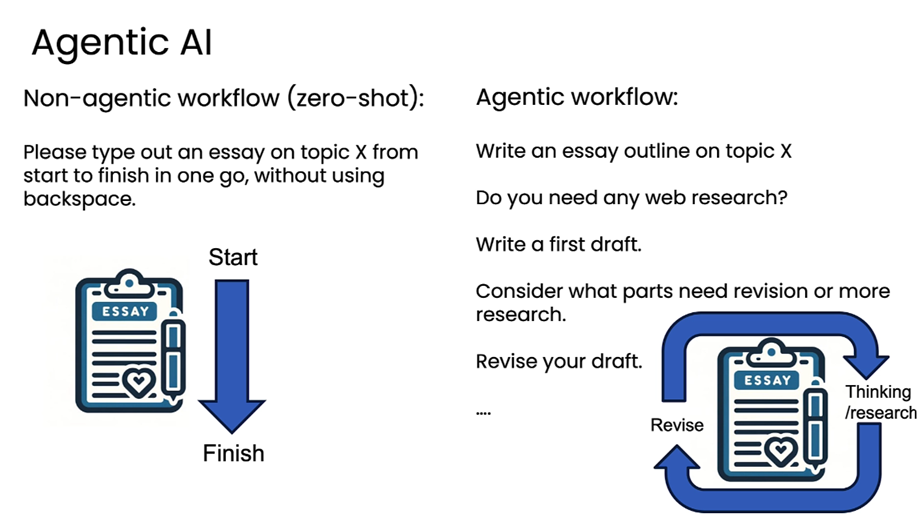

# What are AI Agents?
AI Agents are systems that enable Large Language Models(LLMs) to perform actions by extending their capabilities by giving LLMs access to tools and knowledge.

**Large Language Models** - The concept of agents existed before the creation of LLMs. The advantage of building AI Agents with LLMs is their ability to interpret human language and data. This ability enables LLMs to interpret environmental information and define a plan to change the environment.

**Perform Actions** - Outside of AI Agent systems, LLMs are limited to situations where the action is generating content or information based on a user's prompt. Inside AI Agent systems, LLMs can accomplish tasks by interpreting the user's request and using tools that are available in their environment.

**Access To Tools** - What tools the LLM has access to is defined by 1) the environment it's operating in and 2) the developer of the AI Agent. For our travel agent example, the agent's tools are limited by the operations available in the booking system, and/or the developer can limit the agent's tool access to flights.

**Memory+Knowledge** - Memory can be short-term in the context of the conversation between the user and the agent. Long-term, outside of the information provided by the environment, AI Agents can also retrieve knowledge from other systems, services, tools, and even other agents. In the travel agent example, this knowledge could be the information on the user's travel preferences located in a customer database.



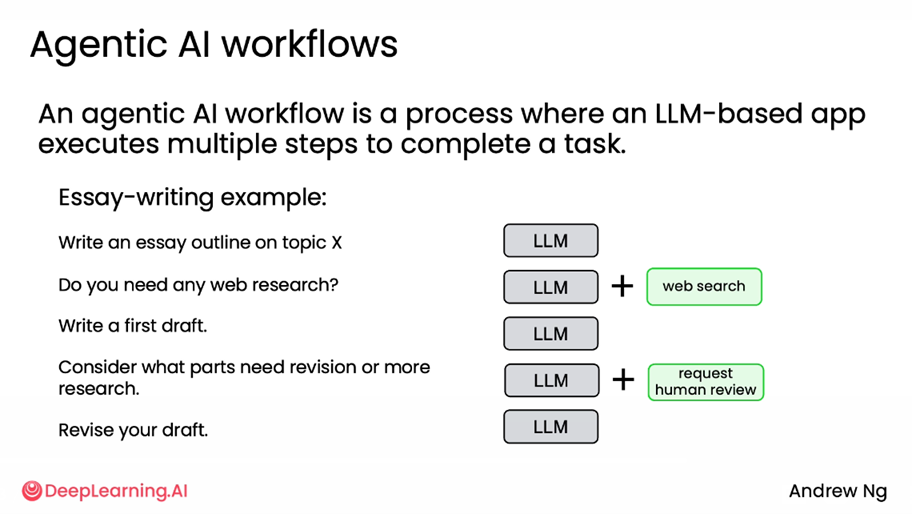

## Different types of agents
Let's look at some specific agent types and how they would be applied to a travel booking AI agent.

| Agent | Type | Description |
|----------|--------------|----------|
| Simple Reflex Agents | Perform immediate actions <br> based on **predefined rules**. | 		Travel agent interprets the context <br> of the email and **forwards** |
| Model-Based Reflex Agents |Perform actions based on a model<br>  of the world and **changes** to that model. | Travel agent prioritizes routes with <br> **significant price changes** based on<br>  access to historical pricing data. |
|Goal-Based Agents | Create plans to achieve **specific<br>  goals** by interpreting the goal <br> and determining actions to reach it.	| Travel agent books a journey by <br> determining necessary **travel <br> arrangements** (car, public transit, flights) <br> from the current location to the destination. |
| Utility-Based Agents	| Consider preferences and **weigh <br> tradeoffs numerically** to determine<br>  how to achieve goals.	| Travel agent **maximizes utility** by weighing <br> convenience vs. cost when booking travel. |
| Learning Agents	| **Improve** over time by responding to<br>  feedback and adjusting actions accordingly.| Travel agent improves by using **customer<br>  feedback** from post-trip surveys to make <br> adjustments to future bookings. |
| Hierarchical Agents	 | Feature **multiple agents** in a tiered system, <br> with higher-level agents breaking tasks <br> into subtasks for lower-level agents to complete. | Travel agent cancels a trip by dividing <br> the task into **subtasks** (for example, <br> canceling specific bookings) and having <br> lower-level agents complete them,<br>  reporting back to the higher-level agent. |
| Multi-Agent Systems (MAS) |	Agents complete tasks **independently**, <br> either cooperatively or competitively. |	**Cooperative**: Multiple agents book specific <br> travel services such as hotels, flights,<br>  and entertainment. <br> **Competitive**: Multiple agents manage and <br> compete over a shared hotel booking <br> calendar to book customers into the hotel. |

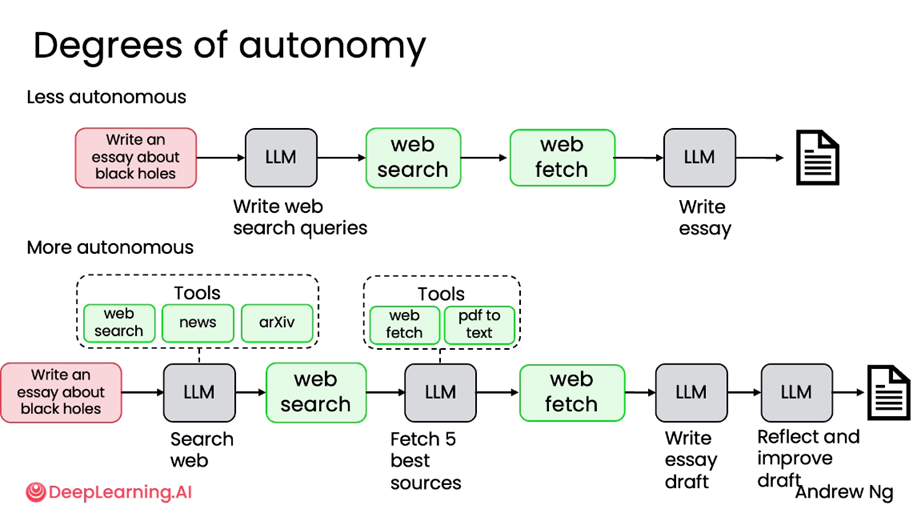

## When to Use AI Agents?

- Open-Ended Problems - allowing the LLM to determine needed steps to complete a task because it can't always be hardcoded into a workflow.
- Multi-Step Processes - tasks that require a level of complexity in which the AI Agent needs to use tools or information over multiple turns instead of single shot retrieval.
- Improvement Over Time - tasks where the agent can improve over time by receiving feedback from either its environment or users in order to provide better utility.

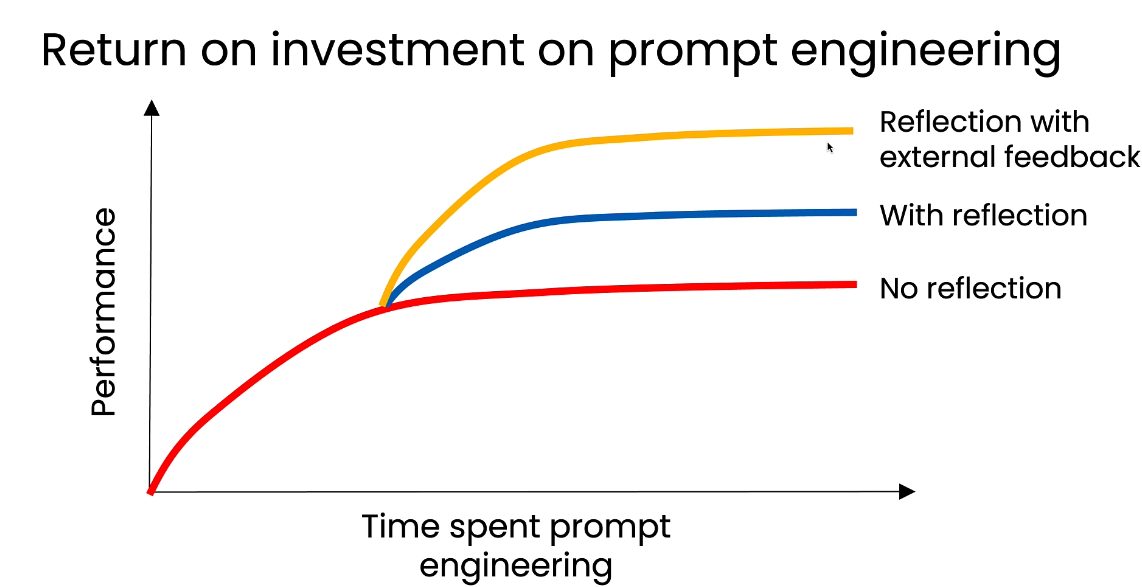

---

## 📚 Part 0: Understanding ReAct Agents

### What is ReAct?

**ReAct** = **Reasoning** + **Acting**

A ReAct agent follows this loop:

```
1. Thought: Reason about what to do next
2. Action: Choose a tool to use
3. Action Input: Provide input to the tool
4. Observation: Receive the tool's output
5. Repeat until you have the final answer
```

### Example

**Question**: "What is the population of France squared?"

**Agent Process**:
```
Thought: I need to find France's population first
Action: Wikipedia
Action Input: France population
Observation: France has approximately 68 million people

Thought: Now I need to square this number
Action: Calculator
Action Input: 68000000 ** 2
Observation: 4624000000000000

Thought: I now know the final answer
Final Answer: 4,624,000,000,000,000
```

---
## 📦 Part 1: Installation

First, let's install the required packages.

In [ ]:
# Install required packages
!pip install -q langchain langchain-openai langchain-community wikipedia python-dotenv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

---
## 🔑 Part 2: Setup OpenAI API

Configure the OpenAI API key. If you're running in an environment with pre-configured API keys, this will use them automatically.

In [ ]:
import os
from random import randint
from dotenv import load_dotenv

# Load environment variables from a .env file
# env_path = "/content/drive/MyDrive/.env"
env_path = "C:\\Users\\vborg\\Git\\.env"
load_dotenv(env_path)

# Set the OpenAI API key environment variable
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

---
## 🤖 Part 3: Initialize the LLM

Let's initialize the GPT model using LangChain's ChatOpenAI wrapper.

In [ ]:
from langchain_openai import ChatOpenAI

# Initialize the LLM
llm = ChatOpenAI(
    model="gpt-3.5-turbo-0125",
    temperature=0,  # Set to 0 for more deterministic outputs
)

# Test the model
response = llm.invoke("What is the capital of France?")
print(f"Test Question: What is the capital of France?")
print(f"Answer: {response.content}")
print("\n✅ LLM initialized successfully!")

In [ ]:
response = llm.invoke("What is the population of France squared?")
print(f"Answer: {response.content}")

---
## 🛠️ Part 4: Create Custom Tools

LangChain allows us to create custom tools that the agent can use. Let's create a Wikipedia search tool and a calculator tool.

In [ ]:
from langchain_community.utilities import WikipediaAPIWrapper
import re

# Initialize Wikipedia wrapper
wikipedia = WikipediaAPIWrapper()

# Create Wikipedia tool
def wikipedia_search(query: str) -> str:
    """
    Search Wikipedia and return a summary.
    """
    try:
        result = wikipedia.run(query)
        return result
    except Exception as e:
        return f"Error searching Wikipedia: {str(e)}"

# Create Calculator tool
def calculator(expression: str) -> str:
    """
    Evaluate a Python mathematical expression.
    """
    try:
        # Clean the expression
        expression = expression.strip()
        # Use eval with a restricted namespace for safety
        result = eval(expression, {"__builtins__": {}}, {})
        return str(result)
    except Exception as e:
        return f"Error evaluating expression: {str(e)}"

print("✅ Custom tools created!")

---
## 🔧 Part 5: Define Tools for LangChain

Now let's wrap our functions as LangChain Tools with proper descriptions.

In [ ]:
from langchain_core.tools import Tool

# Define tools
tools = [
    Tool(
        name="Wikipedia",
        func=wikipedia_search,
        description="Useful for finding factual information about people, places, events, and general knowledge. Input should be a search query."
    ),
    # Add the calculator tool
    # INSERT YOUR CODE HERE
]

print("Available Tools:")
for tool in tools:
    print(f"\n  📌 {tool.name}")
    print(f"     {tool.description}")

---
## 🧪 Part 6: Test the Tools

Let's test our tools individually before integrating them with the agent.

In [ ]:
# Test Wikipedia
print("Testing Wikipedia Tool:")
print("="*50)
result = wikipedia_search("France population")
print(result[:300] + "...")
print()

In [ ]:
# Test Calculator
print("Testing Calculator Tool:")
print("="*50)
result = calculator("68000000 ** 2")
print(f"68000000 ** 2 = {result}")

---
## 🤖 Part 7: Create the ReAct Agent

Now we'll create a ReAct agent using LangChain. LangChain handles all the prompt engineering, parsing, and agent loop logic for us!

In [ ]:
from langchain_classic.agents import create_react_agent, AgentExecutor
from langchain_classic import hub

prompt = hub.pull("hwchase17/react")

agent = create_react_agent(
    llm=llm,
    tools=tools,
    prompt=prompt
)

agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,
    handle_parsing_errors=True,
    max_iterations=5
)

---
## 🎯 Part 8: Run the Agent

Let's test our agent with a question that requires both Wikipedia lookup and calculation.

In [ ]:
# Run the agent with a complex question
question = "What is the population of France squared?"

print(f"\n{'='*70}")
print(f"Question: {question}")
print(f"{'='*70}\n")

result = agent_executor.invoke({"input": question})

print(f"\n{'='*70}")
print(f"✅ Final Answer: {result['output']}")
print(f"{'='*70}")

---
## 📊 Part 9: Understanding the Agent's Process

Let's examine what happened:

### The ReAct Pattern

The agent followed this pattern:

1. **Thought**: "I need to find the population of France first"
2. **Action**: Wikipedia
3. **Action Input**: "France population"
4. **Observation**: [Wikipedia result with population]
5. **Thought**: "Now I need to square this number"
6. **Action**: Calculator
7. **Action Input**: "[population] ** 2"
8. **Observation**: [Calculation result]
9. **Thought**: "I now know the final answer"
10. **Final Answer**: [Result]

### Key Advantages of LangChain

- **No manual prompt engineering**: LangChain uses proven prompts
- **Automatic parsing**: No need to write regex parsers
- **Error handling**: Built-in error recovery
- **Extensibility**: Easy to add more tools
- **Production-ready**: Battle-tested in real applications

---
## 🎯 Part 10: Try Your Own Questions!

Now it's your turn! Try different questions that require reasoning and tool use.

### Good Questions to Try:
- "What is the area of Germany multiplied by 3?"
- "What is 100 plus the population of Tokyo in millions?"
- "What is the square root of the population of Canada?"
- "How many times larger is the population of China compared to France?"
- "How many years ago was the year 2000?"

In [ ]:
# Try your own question!
# INSERT YOUR CODE HERE

---
## 🛠️ Part 11: Adding More Tools

One of the best parts of LangChain is how easy it is to add new tools. Let's add a **Current Date** tool as an example.

In [ ]:
from datetime import datetime

# New tool: Get current date
def get_current_date(query: str = "") -> str:
    """
    Get the current date and year.
    """
    now = datetime.now()
    return f"Today is {now.strftime('%B %d, %Y')}. The current year is {now.year}."

# Add to tools list
current_date_tool = # INSERT YOUR CODE HERE

# Update tools list
tools_with_date = tools + [current_date_tool]

# Create new agent with updated tools
agent_with_date = # INSERT YOUR CODE HERE
agent_executor_with_date = # INSERT YOUR CODE HERE

In [ ]:
print("✅ New tool added!")
print(f"\nAvailable tools: {', '.join([t.name for t in tools_with_date])}")

In [ ]:
# Test with a time-based question
time_question = "How many years ago was the year 2000?"

# INSERT YOUR CODE HERE

print(f"✅ Final Answer: {result['output']}")

---
## 🎨 Part 12: Advanced - Custom Agent with Structured Output

LangChain also supports more advanced agent types. Let's create an agent that returns structured output.

In [ ]:
from langchain_classic.agents import create_structured_chat_agent

# Create a structured chat agent (better for complex reasoning)
prompt = hub.pull("hwchase17/structured-chat-agent")

structured_agent = # INSERT YOUR CODE HERE
structured_executor = # INSERT YOUR CODE HERE

print("✅ Structured chat agent created!")
print("This agent is better at handling complex multi-step reasoning.")

In [ ]:
# Test the structured agent
complex_question = "What is the population of France divided by the population of Germany?"

result = # INSERT YOUR CODE HERE

---
## 🔍 Part 13: Agent with Memory

Let's add conversational memory so the agent can remember previous interactions.

In [ ]:
from langchain_classic.memory import ConversationBufferMemory

# Create memory
memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True
)

# Create agent with memory
agent_with_memory = # INSERT YOUR CODE HERE
executor_with_memory = # INSERT YOUR CODE HERE (memory goes here)

print("✅ Agent with memory created!")
print("The agent can now remember previous questions and answers.")

In [ ]:
# First question
result1 = # INSERT YOUR CODE HERE

In [ ]:
# Follow-up question (uses memory)
result2 = executor_with_memory.invoke({"input": "What is that number squared?"})
print(f"\nAnswer 2: {result2['output']}")